In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.97it/s]


In [3]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [4]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [5]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [6]:
# Changed: Removed the markdown from questions

In [6]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [7]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [8]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [10]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [12]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [13]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [14]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [16]:
#Changed: Added some more keywords2search

In [15]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy",
                  "code here", "pts", "instead", "try", "why",
                  "hint", "Traceback", "most recent call last",
                  "google", "http", "driver"]

keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [43]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,#try,#why,#hint,#traceback,#most recent call last,#google,#http,#driver,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,2.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,2.0,3.0,5.0,6.0,6.0,1.0,0.0,3.0,0.017986,18.850913


In [44]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


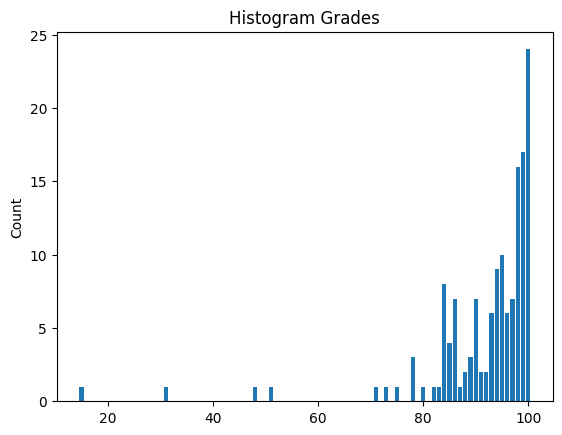

In [45]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [46]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,#try,#why,#hint,#traceback,#most recent call last,#google,#http,#driver,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,2.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,2.0,3.0,5.0,6.0,6.0,1.0,0.0,3.0,0.017986,18.850913


In [47]:
df = pd.merge(df, question_mapping_scores, on="code")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 122
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   code                    123 non-null    object 
 1   #user_prompts           123 non-null    float64
 2   #error                  123 non-null    float64
 3   #no                     123 non-null    float64
 4   #thank                  123 non-null    float64
 5   #next                   123 non-null    float64
 6   #entropy                123 non-null    float64
 7   #code here              123 non-null    float64
 8   #pts                    123 non-null    float64
 9   #instead                123 non-null    float64
 10  #try                    123 non-null    float64
 11  #why                    123 non-null    float64
 12  #hint                   123 non-null    float64
 13  #traceback              123 non-null    float64
 14  #most recent call last  123 non-null    fl

**Running sentiment analysis on every prompt to find the average sentiment of the user throughout the conversation. This might be helpful to us. At this point, we are desperate for any sort of correlation.**

In [23]:
#Changed: This whole part is added later

In [21]:
#Let's start by defining some useful functions

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

def remove_html_tags(text):
    # Use BeautifulSoup to parse the HTML and extract text
    soup = BeautifulSoup(text, 'html.parser')
    
    # Use get_text() to extract text content without HTML tags
    cleaned_text = soup.get_text(separator=' ', strip=True)
    
    return cleaned_text

def remove_punctuation(text):
    remove_these = ['"', '#', '$', '%', '&', "'", '(', ')', '*', 
                    ',', '.', '/', ':', ';', '<', '=', '>', '@', 
                    '[', '\\', ']', '^', '_', '`', '{', '|', '}', 
                    '~', '-', '+', '-', '!', '?']
    for i in remove_these:
        text = text.replace(i, "")
    return text

def remove_stopwords(vector):
    
    new_vector = []
    
    for word in vector:
        if word not in stop_words:
            new_vector.append(word)
        
    return new_vector

def stemming(vector):
    
    new_vector = []
    
    for word in vector:
        new_vector.append(stemmer.stem(word))
    
    return new_vector

def vector_to_string(vector):
    return ' '.join(vector)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARDA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
prompts = []
ID2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            
            unparsed_text = conv["text"]
            
            unparsed_text = remove_html_tags(unparsed_text)
            unparsed_text = unparsed_text.lower()
            unparsed_text = remove_punctuation(unparsed_text)
            
            unparsed_tokens = word_tokenize(unparsed_text)
            unparsed_tokens = remove_stopwords(unparsed_tokens)
            unparsed_tokens = stemming(unparsed_tokens)
            
            parsed_text = vector_to_string(unparsed_tokens)
                
            prompts.append(parsed_text)
            user_prompts.append(parsed_text)
            
    ID2prompts[code] = user_prompts    

C:\Users\ARDA\AppData\Local\Temp\ipykernel_22212\817832833.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [23]:
#Let's see an example
pprint(ID2prompts["0031c86e-81f4-4eef-9e0e-28037abf9883"])

['load csv file panda python file name cs412hw1datasetcsv contain column like '
 'speci island sex diet year life stage bodi mass g bill length mm bill depth '
 'mm flipper length mm health metric',
 'provid python code understand dataset use panda find shape dataset display '
 'variabl name display summari dataset info function show first 5 row use head '
 'function',
 'preprocess data 1 check miss valu handl either drop fill common valu ensur '
 'enough data train model use 80 data train 20 test 2 encod label map use map '
 'function map name sexmap femal 1 male 0 islandmap bisco 1 dream 2 torgensen '
 '3 dietmap fish 1 krill 2 squid 3 parent 4 lifestagemap chick 1 juvenil 2 '
 'adult 3 healthmetricsmap healthi 1 overweight 2 underweight 3 dataset name '
 'df',
 'alreadi provid code pleas recreat part shuffl need 1 shuffl datafram name df '
 '2 separ dataset featur matrix x target vector column healthmetr column '
 'includ x 3 split data train test set 80 data train 20 test ensur spl

In [27]:
#Now, let us use a pretrained sentiment classifier from huggingface

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

#Get the huggingface model from https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

#Calculate the sentiment score for a text
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    return logits.softmax(dim=-1).detach().numpy()[0]

negative_df = pd.DataFrame(columns=['ID', 'Avg Neg Sent'])
neutral_df = pd.DataFrame(columns=['ID', 'Avg Neut Sent'])
positive_df = pd.DataFrame(columns=['ID', 'Avg Pos Sent'])

#Max sequence length is 512 for this model, so we limit
for user_id, texts in tqdm(ID2prompts.items(), desc="Calculating Sentiment"):
    user_sentiment_scores = [get_sentiment(text[:512:]) for text in texts]
    #stop div by 0
    if(len(user_sentiment_scores) != 0):
        sum_neg = 0
        sum_neut = 0
        sum_pos = 0
        for sentiment in user_sentiment_scores:
            sum_neg += sentiment[0]
            sum_neut += sentiment[1]
            sum_pos += sentiment[2]
        avg_neg = sum_neg / len(user_sentiment_scores)
        avg_neut = sum_neut / len(user_sentiment_scores)
        avg_pos = sum_pos / len(user_sentiment_scores)   
    else:
        avg_neg = 0
        avg_neut = 0
        avg_pos = 0  
    neg_row = pd.DataFrame({'ID': [user_id], 'Avg Neg Sent': [avg_neg]})
    neut_row = pd.DataFrame({'ID': [user_id], 'Avg Neut Sent': [avg_neut]})
    pos_row = pd.DataFrame({'ID': [user_id], 'Avg Pos Sent': [avg_pos]})
    negative_df = pd.concat([negative_df, neg_row], ignore_index=True)
    neutral_df = pd.concat([neutral_df, neut_row], ignore_index=True)
    positive_df = pd.concat([positive_df, pos_row], ignore_index=True)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Calculating Sentiment: 100%|█████████████████████████████████████████████████████████| 127/127 [05:47<00:00,  2.74s/it]


In [29]:
#[0] is for negative, [1] is for neutral, [2] for positive
print(get_sentiment("I hate you"))
print(get_sentiment("I think therefore I am"))
print(get_sentiment("I love you"))

[0.7866935  0.18048044 0.03282604]
[0.05402553 0.80769175 0.1382827 ]
[0.01813324 0.12239732 0.8594694 ]


In [36]:
negative_df.head()

,ID,Avg Neg Sent
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.130663
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.089839
2,041f950b-c013-409a-a642-cffff60b9d4b,0.359546
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.115667
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.139420


In [31]:
neutral_df.head()

,ID,Avg Neut Sent
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.819262
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.850928
2,041f950b-c013-409a-a642-cffff60b9d4b,0.516458
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.808555
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.774099


In [33]:
positive_df.head()

,ID,Avg Pos Sent
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.050074
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.059234
2,041f950b-c013-409a-a642-cffff60b9d4b,0.123996
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.075778
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.086480


In [48]:
sentiment_df = negative_df
sentiment_df = pd.merge(sentiment_df, neutral_df, on='ID', how='inner')
sentiment_df = pd.merge(sentiment_df, positive_df, on='ID', how='inner')

sentiment_df.head()   

,ID,Avg Neg Sent,Avg Neut Sent,Avg Pos Sent
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.130663,0.819262,0.050074
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.089839,0.850928,0.059234
2,041f950b-c013-409a-a642-cffff60b9d4b,0.359546,0.516458,0.123996
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.115667,0.808555,0.075778
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.139420,0.774099,0.086480


In [49]:
#Let's merge sentiment_df with the first df we created which has everything but scores at this point

df = df.rename(columns={'code': 'ID'})

df = pd.merge(df, sentiment_df, on='ID', how='inner')

df.head()

,ID,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,...,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Avg Neg Sent,Avg Neut Sent,Avg Pos Sent
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,0.130663,0.819262,0.050074
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,...,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,0.089839,0.850928,0.059234
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,...,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,0.359546,0.516458,0.123996
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,...,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,0.115667,0.808555,0.075778
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,...,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,0.139420,0.774099,0.086480


In [50]:
#Changed: Lastly, get and merge the submission dates with our dataset:

dates_path = "dates.txt" #We scraped this information elsewhere
columns = ["ID", "date"]

dates_df = pd.read_csv(dates_path, sep=' ', header=None, names=columns)

#Let's represent each date as its distance from the latest submission date
lastest = dates_df['date'].max()
dates_df['date'] = abs(lastest - dates_df['date'])

df = pd.merge(df, dates_df, on='ID')

df.head()

,ID,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,...,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Avg Neg Sent,Avg Neut Sent,Avg Pos Sent,date
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,0.130663,0.819262,0.050074,0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,...,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,0.089839,0.850928,0.059234,0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,...,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,0.359546,0.516458,0.123996,0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,...,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,0.115667,0.808555,0.075778,16
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,...,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,0.139420,0.774099,0.086480,0


#### Merging scores with features

In [51]:
#Let's finally merge everything with scores
scores = scores.rename(columns={'code': 'ID'})
df = pd.merge(df, scores, on='ID', how="left")
df.dropna(inplace=True)
df.drop_duplicates("ID",inplace=True, keep="first")

df.head()

,ID,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,...,Q_4,Q_5,Q_6,Q_7,Q_8,Avg Neg Sent,Avg Neut Sent,Avg Pos Sent,date,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.460606,0.553876,0.167250,0.182938,0.195440,0.130663,0.819262,0.050074,0,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,...,0.607114,0.987511,0.892586,0.570741,0.543866,0.089839,0.850928,0.059234,0,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,...,0.643038,0.454314,0.540269,0.546506,0.325793,0.359546,0.516458,0.123996,0,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,...,0.333889,0.309084,0.192434,0.261892,0.407106,0.115667,0.808555,0.075778,16,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,...,0.724872,0.872171,0.684797,0.945305,0.511769,0.139420,0.774099,0.086480,0,100.0


In [53]:
#Changed: Now, let's factor in the weights of the questions as well

#Drop Q_0 since it has no points
df = df.drop('Q_0', axis=1)

df["Q_1"] = df["Q_1"] * 5
df["Q_2"] = df["Q_2"] * 15
df["Q_3"] = df["Q_3"] * 5  
df["Q_4"] = df["Q_4"] * 10
df["Q_5"] = df["Q_5"] * 20
df["Q_6"] = df["Q_6"] * 15
df["Q_7"] = df["Q_7"] * 20
df["Q_8"] = df["Q_8"] * 10

#This will be explained shortly
threshold = df.grade.quantile(0.25)
condition = (df['grade'] <= threshold)
df['low'] = 0
df.loc[condition, 'low'] = 1

df.head()

,ID,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,...,Q_5,Q_6,Q_7,Q_8,Avg Neg Sent,Avg Neut Sent,Avg Pos Sent,date,grade,low
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,11.077513,2.508756,3.658762,1.954398,0.130663,0.819262,0.050074,0,48.0,1
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,...,19.750224,13.388784,11.414811,5.438659,0.089839,0.850928,0.059234,0,99.0,0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,...,9.086289,8.104040,10.930117,3.257926,0.359546,0.516458,0.123996,0,90.0,0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,...,6.181681,2.886515,5.237849,4.071058,0.115667,0.808555,0.075778,16,97.0,0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,...,17.443416,10.271962,18.906107,5.117691,0.139420,0.774099,0.086480,0,100.0,0


In [54]:
X = df[df.columns[1:-1]].to_numpy() #includes grades!!!
y_binary = df["low"].to_numpy()

print(X.shape, y_binary.shape)

(122, 32) (122,)


#### Train/Test split

In [92]:
#Changed
#Since we have so little data, startification doesn't really work because we don't have enough different
#y values. So instead, I wrote this simple code to split it until we get a good result. I would have used
#StratifiedShuffleSplit or something similar if we had more data.

import random

def countOnes(array):
    numOnes = 0
    for num in array:
        if num == 1:
            numOnes += 1
    return numOnes
        
condition = True
iteration_count = 0

while condition:
    random_state_used = random.randint(0,100)
    X_train, X_test, y_binary_train, y_binary_test = train_test_split(X, y_binary, test_size=0.2, random_state=random_state_used)
    y_binary_train_ones = countOnes(y_binary_train)
    y_binary_test_ones = countOnes(y_binary_test)
    train_ratio = y_binary_train_ones/len(X_train)
    test_ratio = y_binary_test_ones/len(X_test)
    condition = (abs(train_ratio - test_ratio) >= 0.1)
    iteration_count += 1
    
print("Train set size and number of 1's:", len(X_train), y_binary_train_ones)
print("Test set size and number of 1's:", len(X_test), y_binary_test_ones)
print("Arrived at this with {} iteration(s). Random state is {}".format(iteration_count, random_state_used))

Train set size and number of 1's: 97 26
Test set size and number of 1's: 25 5
Arrived at this with 1 iteration(s). Random state is 19


In [93]:
#Removed grades info
X_binary_train = X_train[:, :-1]
X_binary_test = X_test[:, :-1]

print(X_binary_train.shape)
print(X_train.shape)

(97, 31)
(97, 32)


#### Fitting a model

In [97]:
#Changed: Let's train a binary classification neural network for finding low scores

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers

binary_model = keras.Sequential([
    layers.Dense(64, input_shape=(31,), activation='relu'), #We set the input shape 31 since we have 31 features
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  #Sigmoid activation for values between 0 and 1
])

#Compile the model
binary_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(binary_model.summary())

#Train the model
history = binary_model.fit(X_binary_train, y_binary_train, epochs=4, batch_size=16, validation_split=0.2)

#Evaluate the model on the test set
loss, accuracy = binary_model.evaluate(X_binary_test, y_binary_test)
print(f"Test Accuracy: {accuracy:.2f}")

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 64)                2048      
                                                                 
 dense_64 (Dense)            (None, 32)                2080      
                                                                 
 dense_65 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,161
Trainable params: 4,161
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
5/5 [==============================] - 1s 51ms/step - loss: 0.9872 - accuracy: 0.6494 - val_loss: 0.4897 - val_accuracy: 0.7000
Epoch 2/4
5/5 [==============================] - 0s 44ms/step - loss: 0.7011 - accuracy: 0.6364 - val_loss: 0.5242 - val_accuracy: 0.6500
Epoch 3/4
5/5 [===================

1/1 [==============================] - 0s 69ms/step


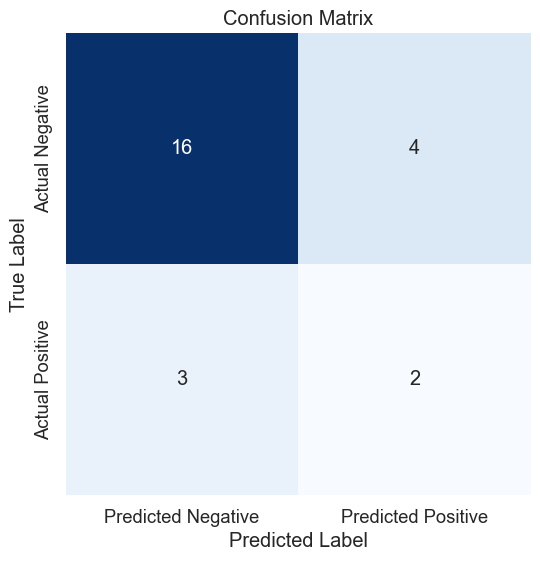

    Actual  Predicted
0        0        0.0
1        0        0.0
2        0        0.0
3        0        0.0
4        0        0.0
5        0        1.0
6        0        1.0
7        0        0.0
8        0        0.0
9        1        0.0
10       0        0.0
11       0        0.0
12       0        0.0
13       1        0.0
14       0        1.0
15       0        0.0
16       0        1.0
17       0        0.0
18       0        0.0
19       0        0.0
20       1        1.0
21       0        0.0
22       1        1.0
23       1        0.0
24       0        0.0


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Make predictions
predictions = binary_model.predict(X_binary_test)
binary_predictions = np.round(predictions).flatten()

conf_matrix = confusion_matrix(y_binary_test, binary_predictions)

# Display the confusion matrix using seaborn and matplotlib
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the plot
plt.show()

#Compare predictions with actual scores
binary_comparison_df = pd.DataFrame({'Actual': y_binary_test, 'Predicted': binary_predictions})
print(binary_comparison_df)

In [99]:
#Get grades info
y_train = X_train[:, 31:]
y_test = X_test[:, 31:]

#Remove grades info
X_train = X_train[:, :-1]
X_test = X_test[:, :-1]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(97, 31)
(25, 31)
(97, 1)
(25, 1)


In [100]:
#Squeeze these
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

print(y_test)

[ 97.  96.  93.  90.  98.  99. 100. 100. 100.  88.  92.  98.  99.  89.
  94.  96. 100.  97.  99.  97.  84.  90.  15.  78.  94.]


In [101]:
print(y_train.shape)
print(y_test.shape)

(97,)
(25,)


In [102]:
#Now, we have X_train, X_test, y_train, y_test ready for use, labels as grades, features as everything else but 'low'

#Concatenate predictions from binary classification model to the training and test features

#X_train
train_predictions = binary_model.predict(X_binary_train)
binary_predictions_train = np.round(train_predictions).flatten()
#Reshape the new values
binary_predictions_train = binary_predictions_train.reshape((X_train.shape[0], 1))
#Append the new values to the existing array
X_train_latest = np.concatenate((X_train, binary_predictions_train), axis=1)

#X_test
test_predictions = binary_model.predict(X_binary_test)
binary_predictions_test = np.round(test_predictions).flatten()
#Reshape the new values
binary_predictions_test = binary_predictions_test.reshape((X_test.shape[0], 1))
#Append the new values to the existing array
X_test_latest = np.concatenate((X_test, binary_predictions_test), axis=1)


print(X_train_latest.shape)
print(X_test_latest.shape)

1/1 [==============================] - 0s 25ms/step
(97, 32)
(25, 32)


In [103]:
#Changed: Let's train a simple neural network for finding a relation between all these features and the grade

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, input_shape=(32,), activation='relu'), #We set the input shape 32 since we have 32 features
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  #Sigmoid activation for values between 0 and 1
])

#Scale the output to be in the range of 0 to 100
model.add(layers.Lambda(lambda x: x * 100))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print(model.summary())

#Train the model
history = model.fit(X_train_latest, y_train, epochs=4, batch_size=16, validation_split=0.2)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 128)               4224      
                                                                 
 dense_67 (Dense)            (None, 32)                4128      
                                                                 
 dense_68 (Dense)            (None, 1)                 33        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
5/5 [==============================] - 2s 63ms/step - loss: 4606.4990 - mae: 60.2522 - val_loss: 247.1429 - val_mae: 7.7977
Epoch 2/4
5/5 [=============================

In [104]:
#Make predictions
predictions = model.predict(X_test_latest)

#Compare predictions with actual scores
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})
print(comparison_df)

1/1 [==============================] - 0s 70ms/step
    Actual   Predicted
0     97.0   99.966873
1     96.0   99.985054
2     93.0   99.999931
3     90.0   97.460190
4     98.0   98.051086
5     99.0   99.998169
6    100.0  100.000000
7    100.0   99.999817
8    100.0   99.999947
9     88.0  100.000000
10    92.0  100.000000
11    98.0   99.999695
12    99.0  100.000000
13    89.0   99.999878
14    94.0  100.000000
15    96.0   99.999985
16   100.0  100.000000
17    97.0  100.000000
18    99.0  100.000000
19    97.0   99.995987
20    84.0  100.000000
21    90.0   99.989761
22    15.0  100.000000
23    78.0   99.993286
24    94.0   99.999969


**On 22nd line we predicted that someone who got 15 got 100. This is really bad. Our model has a low MAE because it just assigns every student high grades, and since most people got high grades from the homework, this does not seem to be useful.**

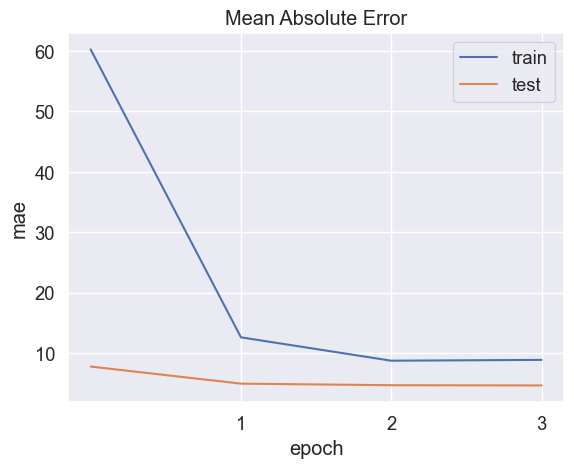

In [105]:
#Let's visualize the mean absolute error

#print(history.history.keys())

plt.plot(history.history['mae']) 
plt.plot(history.history['val_mae']) 
plt.title('Mean Absolute Error') 
plt.ylabel('mae') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper right') 
plt.xticks(range(1, 4))
plt.show()

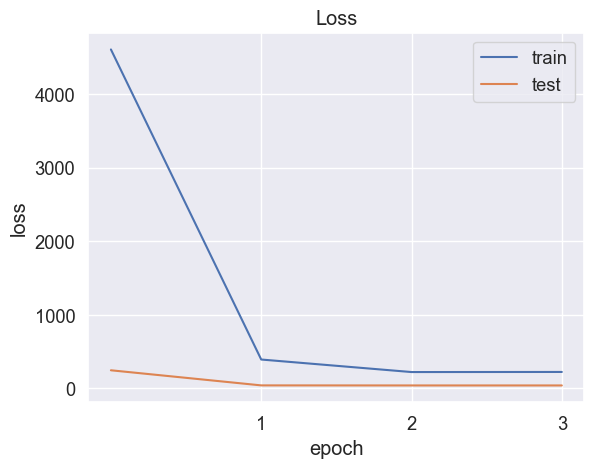

In [106]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper right') 
plt.xticks(range(1, 4))
plt.show()

In [107]:
#Let's try a simpler model like a random forest.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfClassifier = RandomForestClassifier(n_estimators=100, random_state=42)

#Yyperparameter for gridcv
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rfClassifier, param_grid=param_grid, 
                           scoring='r2', cv=3, n_jobs=-1)


#Fit the model
grid_search.fit(X_train_latest, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

best_model = grid_search.best_estimator_

#Train the model
best_model.fit(X_train_latest, y_train)

# Predictions
y_train_pred = best_model.predict(X_train_latest)
y_test_pred = best_model.predict(X_test_latest)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("R2 Train:", r2_score(y_train,y_train_pred))

print("MSE Test:", mean_squared_error(y_test,y_test_pred))
print("R2 Test:", r2_score(y_test,y_test_pred))

C:\Users\ARDA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
MSE Train: 45.45360824742268
R2 Train: 0.628097499043445
MSE Test: 339.12
R2 Test: -0.24650074101954877


**This is, unfortunately, not very useful again. Meh performance on training and on horrible performance on test.**

#### Predicting and Analyzing 

In [108]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train_latest, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [109]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 122.21915187586274
Node 1 has MSE 84.5
Node 2 has MSE 0.0
Node 3 has MSE 64.32531855955676
Node 4 has MSE 151.66759002770232
Node 5 has MSE 73.82698961937785
Node 6 has MSE 59.88999999999851
Node 7 has MSE 32.33333333333303
Node 8 has MSE 9.0
Node 9 has MSE 0.0
Node 10 has MSE 0.0
Node 11 has MSE 7.25
Node 12 has MSE 1.0
Node 13 has MSE 0.0
Node 14 has MSE 0.0
Node 15 has MSE 1.0
Node 16 has MSE 0.0
Node 17 has MSE 0.0
Node 18 has MSE 11.1875
Node 19 has MSE 0.0
Node 20 has MSE 0.22222222222262644
Node 21 has MSE 0.0
Node 22 has MSE 0.0
Node 23 has MSE 28.530612244896474
Node 24 has MSE 6.25
Node 25 has MSE 0.0
Node 26 has MSE 0.0
Node 27 has MSE 2.2400000000016007
Node 28 has MSE 0.22222222222080745
Node 29 has MSE 0.0
Node 30 has MSE 0.0
Node 31 has MSE 1.0
Node 32 has MSE 0.0
Node 33 has MSE 0.0
Node 34 has MSE 100.0
Node 35 has MSE 0.0
Node 36 has MSE 0.0
Node 37 has MSE 28.43957756232885
Node 38 has MSE 26.063002191380292
Node 39 has MSE 23.729418766117305
Node 40 h

In [43]:
# Plotting the Tree 
#dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
#graph = graphviz.Source(dot_data)
#graph.render("hw")

In [110]:
# Prediction
y_train_pred = regressor.predict(X_train_latest)
y_test_pred = regressor.predict(X_test_latest)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 7.168113225486601
MSE TEST: 389.7955068818447
R2 Train: 0.941350327543042
R2 TEST: -0.4327683067183006


**This is a case of overfitting. We have good R2 and MSE on training data, but we are doing horribly on test data. This single tree is not useful either.**

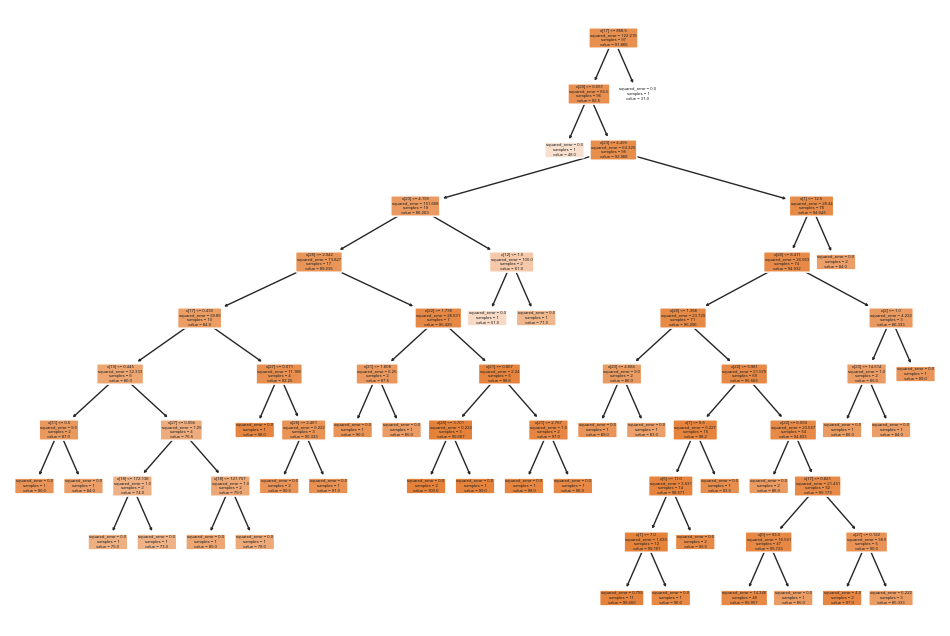

In [111]:
#Let's see what this tree looks like (without graphviz)

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(regressor, filled=True, rounded=True)
plt.show()